In [26]:
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

In [1]:
_tmp = __import__("dse-user_vars_ren")
globals().update(vars(_tmp))

In [23]:
def simulate_game(tracked_stats, debug=False):
    # playing loose and fast with global scope here because that's the expected behavior in renpy and this isn't oop
    result = False
    day = 0
    tracking = {k:[] for k in tracked_stats}
    reset() # resets stat store variables
    e = EventDispatchSimulator()
    while not result:
        day += 1
        events = e.start_day()
        choices = e.get_choices()
        
        # TODO: implement player strategy here instead of just choosing randomly
        acts = {k: random.choice(choices[k]) for k in choices.keys()}
        
        if debug:
            print(f"day {day}, { {k: events[v] for k,v in acts.items()} }")
        
        result = e.run_day(acts)
        for stat in tracked_stats:
            tracking[stat].append(getattr(store, stat))
    
    return result, tracking

def montecarlo(tracked_stats, n=100, debug=False):
    endings = {}
    stats = {}
    for i in range(n):
        result, tracking = simulate_game(tracked_stats, debug)
        runtime = len(tracking[tracked_stats[0]]) # number of turns to reach ending
        if result in endings.keys():
            endings[result].append(runtime)
        else:
            endings[result] = [runtime]
        for stat in tracked_stats:
            if stat not in stats.keys():
                stats[stat] = []
            
            for i in range(runtime):
                if i >= len(stats[stat]):
                    stats[stat].append([tracking[stat][i]])
                else:
                    #print(stats[stat])
                    #print(tracking[stat][i])
                    stats[stat][i].append(tracking[stat][i])
    return endings, stats        

In [25]:
n = 100
endings, stats = montecarlo(["intelligence","strength","relaxation"], n)

In [36]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average\n\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")

relaxed_ending:
	92 times (92.00%)
	18.78 days average
	6.64 days stdev
	7-38 turn range
gg_confess:
	8 times (8.00%)
	26.38 days average
	4.21 days stdev
	22-35 turn range


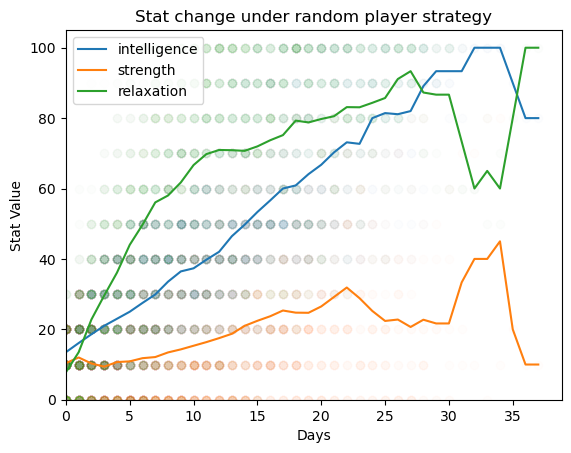

In [57]:
lines = {}
for stat, values in stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under random player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()